In [1]:
import torch
import torchvision
from torchvision import transforms
from skimage import io, transform
from torch import nn

import json

import numpy as np

from training.losses import *
from training.train import *
from training.plots import *
from models.gan import *
from models.classifier import *

import matplotlib.pyplot as plt
from PIL import Image
from importlib import reload
%matplotlib inline

In [2]:
BATCH_SIZE = 128
LR = 3e-4
BETAS = 0.9, 0.999

In [3]:
data = torchvision.datasets.MNIST("./../data/mnist", download=True, train=True, transform=lambda x: torch.tensor(transform.resize(np.array(x), (10, 10))).unsqueeze(0))
train_data = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, drop_last=True)

In [4]:
base_classifier = SimpleClassifier()

In [5]:
optimizer = torch.optim.Adam(base_classifier.parameters(), lr=LR, betas=BETAS)
criterion = nn.CrossEntropyLoss()

In [6]:
base_classifier_trainer = BaseClassifierTrainer(base_classifier, criterion, optimizer, 'cpu')

In [7]:
base_res = base_classifier_trainer.train(train_data, 1)

Epoch: 0, Loss: 0.5872347354092914


In [48]:
data = torchvision.datasets.MNIST("./../data/mnist", download=True, train=False, transform=lambda x: torch.tensor(transform.resize(np.array(x), (10, 10))).unsqueeze(0))
train_data = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, drop_last=True)

In [49]:
generator_model = Generator()
discriminator_model = Discriminator()
attacked_model = base_classifier.eval()

In [50]:
generator_optimizer = torch.optim.Adam(generator_model.parameters(), lr=LR, betas=BETAS)
discriminator_optimizer = torch.optim.Adam(discriminator_model.parameters(), lr=LR, betas=BETAS)

In [51]:
# trainer = Trainer(generator_model, discriminator_model, attacked_model,
#                   GANLoss(BATCH_SIZE, 'cpu'),
#                   AttackLoss(attacked_model, BATCH_SIZE),
#                   HingeLoss(attacked_model, BATCH_SIZE, 'cpu'),
#                   discriminator_optimizer, generator_optimizer, 'cpu')

In [52]:
# res = trainer.train(train_data, 10)

In [53]:
model = {"generator": generator_model, "discriminator": discriminator_model, 'attacked_model': attacked_model}
criterion = {"generator_loss": GeneratorLoss(BATCH_SIZE, 'cpu'), 
             "discriminator_loss": DiscriminatorLoss(BATCH_SIZE, 'cpu'), 
             "attack_loss": MAttackLoss(attacked_model, BATCH_SIZE),
             "hinge_loss": MHingeLoss(attacked_model, BATCH_SIZE, 'cpu')}
optimizer = {
    "generator_optimizer": generator_optimizer,
    "discriminator_optimizer": discriminator_optimizer,
}
loaders = {
    "train": train_data
}

In [54]:
torch.autograd.set_detect_anomaly(True)

In [55]:
GeneratorLoss(BATCH_SIZE, 'cpu').state_dict()

OrderedDict()

In [56]:
runner = GANRunner("./logs_gan_final", 'cpu')

In [59]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    num_epochs=2,
    verbose=True,
    logdir="./logs_gan_final",
)


train (1/2) 


KeyError: 'generator loss'

In [19]:
runner

In [37]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from catalyst import dl
from catalyst.contrib.datasets import MNIST
from catalyst.contrib.nn.modules import Flatten, GlobalMaxPool2d, Lambda
from catalyst.data.transforms import ToTensor

latent_dim = 128
generator = nn.Sequential(
    # We want to generate 128 coefficients to reshape into a 7x7x128 map
    nn.Linear(128, 128 * 7 * 7),
    nn.LeakyReLU(0.2, inplace=True),
    Lambda(lambda x: x.view(x.size(0), 128, 7, 7)),
    nn.ConvTranspose2d(128, 128, (4, 4), stride=(2, 2), padding=1),
    nn.LeakyReLU(0.2, inplace=True),
    nn.ConvTranspose2d(128, 128, (4, 4), stride=(2, 2), padding=1),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(128, 1, (7, 7), padding=3),
    nn.Sigmoid(),
)
discriminator = nn.Sequential(
    nn.Conv2d(1, 64, (3, 3), stride=(2, 2), padding=1),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64, 128, (3, 3), stride=(2, 2), padding=1),
    nn.LeakyReLU(0.2, inplace=True),
    GlobalMaxPool2d(),
    Flatten(),
    nn.Linear(128, 1),
)

model = {"generator": generator, "discriminator": discriminator}
criterion = {"generator": nn.BCEWithLogitsLoss(), "discriminator": nn.BCEWithLogitsLoss()}
optimizer = {
    "generator": torch.optim.Adam(generator.parameters(), lr=0.0003, betas=(0.5, 0.999)),
    "discriminator": torch.optim.Adam(discriminator.parameters(), lr=0.0003, betas=(0.5, 0.999)),
}
loaders = {
    "train": DataLoader(
        MNIST(os.getcwd(), train=False, download=True, transform=ToTensor()), batch_size=32
    )
}

class CustomRunner(dl.Runner):
    def predict_batch(self, batch):
        batch_size = 1
        # Sample random points in the latent space
        random_latent_vectors = torch.randn(batch_size, latent_dim).to(self.device)
        # Decode them to fake images
        generated_images = self.model["generator"](random_latent_vectors).detach()
        return generated_images

    def handle_batch(self, batch):
        real_images, _ = batch
        batch_size = real_images.shape[0]

        # Sample random points in the latent space
        random_latent_vectors = torch.randn(batch_size, latent_dim).to(self.device)

        # Decode them to fake images
        generated_images = self.model["generator"](random_latent_vectors).detach()
        # Combine them with real images
        combined_images = torch.cat([generated_images, real_images])

        # Assemble labels discriminating real from fake images
        labels = \
            torch.cat([torch.ones((batch_size, 1)), torch.zeros((batch_size, 1))]).to(self.device)
        # Add random noise to the labels - important trick!
        labels += 0.05 * torch.rand(labels.shape).to(self.device)

        # Discriminator forward
        combined_predictions = self.model["discriminator"](combined_images)

        # Sample random points in the latent space
        random_latent_vectors = torch.randn(batch_size, latent_dim).to(self.device)
        # Assemble labels that say "all real images"
        misleading_labels = torch.zeros((batch_size, 1)).to(self.device)

        # Generator forward
        generated_images = self.model["generator"](random_latent_vectors)
        generated_predictions = self.model["discriminator"](generated_images)

        self.batch = {
            "combined_predictions": combined_predictions,
            "labels": labels,
            "generated_predictions": generated_predictions,
            "misleading_labels": misleading_labels,
        }


runner = CustomRunner()
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    callbacks=[
        dl.CriterionCallback(
            input_key=["combined_predictions","generated_predictions"],
            target_key="labels",
            metric_key="loss_discriminator",
            criterion_key="discriminator",
        ),
        dl.CriterionCallback(
            input_key="generated_predictions",
            target_key="misleading_labels",
            metric_key="loss_generator",
            criterion_key="generator",
        ),
        dl.OptimizerCallback(
            model_key="generator", 
            optimizer_key="generator", 
            metric_key="loss_generator"
        ),
        dl.OptimizerCallback(
            model_key="discriminator", 
            optimizer_key="discriminator", 
            metric_key="loss_discriminator"
        ),
    ],
    valid_loader="train",
    valid_metric="loss_generator",
    minimize_valid_metric=True,
    num_epochs=20,
    verbose=True,
    logdir="./logs_gan",
)

# visualization (matplotlib required):
# import matplotlib.pyplot as plt
# %matplotlib inline
# plt.imshow(runner.predict_batch(None)[0, 0].cpu().numpy())

NotImplementedError: 

In [20]:
val_batch = iter(train_data).next()
for i in range(16):
    print(F.softmax(attacked_model(val_batch[0].float()), -1).cpu().detach().numpy()[i, val_batch[1][i]], F.softmax(attacked_model(val_batch[0].float() + generator_model(val_batch[0].float())), -1).cpu().detach().numpy()[i, val_batch[1][i]])
    print(val_batch[1][i])

0.9928241 0.06857386
tensor(7)
0.83737624 0.024263348
tensor(2)
0.98327374 0.003856659
tensor(1)
0.9612411 0.046703976
tensor(0)
0.9256049 0.002511471
tensor(4)
0.98170286 0.0047882143
tensor(1)
0.9361239 0.0065191835
tensor(4)
0.41521212 0.02264449
tensor(9)
0.78929216 0.2208246
tensor(5)
0.8605434 0.046557672
tensor(9)
0.960241 0.015112878
tensor(0)
0.89207643 0.0032921853
tensor(6)
0.9146951 0.026506502
tensor(9)
0.96590924 0.012912119
tensor(0)
0.9801048 0.005365443
tensor(1)
0.94892144 0.17559448
tensor(5)


Text(0.5, 1.0, 'Fake: Prediction: 3, confidence: 0.7148659825325012')

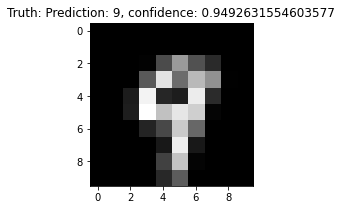

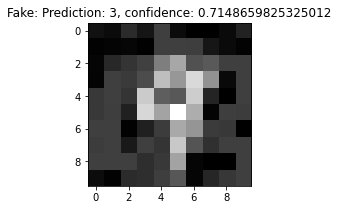

In [21]:
test_img = val_batch[0].float()[12:13]
true_confs = F.softmax(attacked_model(test_img), -1).cpu().detach().numpy()[0]
fake_confs = F.softmax(attacked_model(test_img + generator_model(test_img)), -1).cpu().detach().numpy()[0]

plt.figure(figsize=(3,3))
plt.imshow(test_img[0, 0] * 127.5 + 127.5, cmap='gray')
plt.title("Truth: Prediction: {}, confidence: {}".format(np.argmax(true_confs), true_confs.max()))

plt.figure(figsize=(3,3))
plt.imshow((test_img + generator_model(test_img).cpu().detach().numpy())[0,  0] * 127.5 + 127.5, cmap='gray')
plt.title("Fake: Prediction: {}, confidence: {}".format(np.argmax(fake_confs), fake_confs.max()))

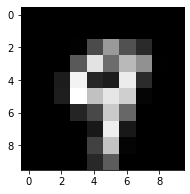

In [23]:
plt.figure(figsize=(3,3))
plt.imshow(test_img[0, 0] * 127.5 + 127.5, cmap='gray')

NameError: name 'res' is not defined

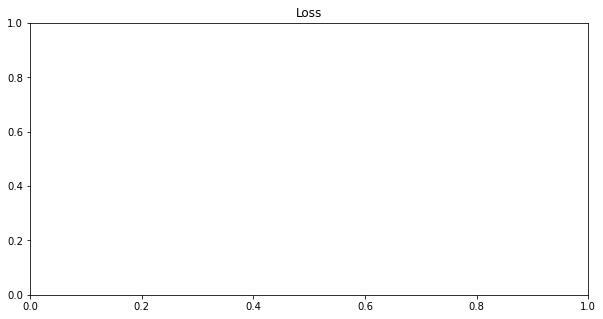

In [22]:
plt.figure(figsize=(10,5))
plt.title("Loss")
plt.plot(res[0],label="Generator loss")
plt.plot(res[1],label="Discriminator loss")
plt.plot(res[2],label="Attack loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [30]:
dl.CSVLogger(logdir='./test_dir').log_metrics({'1': 78, '2': 789})